# Post-Processing (General)

#### Updated: May 17, 2023

#  

Post-processing pipeline after stage 2 of Alouette processing (OCR processing stage):

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [2]:
rootDir = 'L:/DATA/Alouette_I/BATCH_I_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [3]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory, concatenate stage 1 results - RUN BEFORE starting stage 2 processing (OCR processing stage):

Generate processed_inventory:

In [ ]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

In [ ]:
print(len(df_inventory))
df_inventory.head()

In [ ]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

Concatenate stage 1 results:

In [ ]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result-' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[1].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                    df_load = pd.DataFrame()
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)

In [ ]:
df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
print(len(df_result))
df_result.sample(10)

#  

#### Concatenate 'OCR pass' results - START HERE after stage 2 processeing (OCR processing stage):

In [4]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)

Now saving the 100th result...
32976


#  

#### Reduce columns:

In [5]:
df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
print(len(df_result))
df_result.head()

39255


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,y_centroids,is_dot,dict_metadata,raw_coord,window_coord,mapping_Hz,mapping_km,station_code,station_number,rotated_metadata
0,1.612903,1561.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.620968,1753.846154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.608871,856.410256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.625000,1433.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.625000,1305.128205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
13393,R014207929F,470,Image0072.png,dot,1.616935,1330.232558,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14230,R014207938,929-B,204.png,num,1.637097,1203.773585,NaN,0.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17163,R014207942,1975-5B,39.png,num,10.753846,1440.000000,NaN,0.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5472,R014207823,3590-50A,253.png,loss,1.520161,1951.612903,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
13659,R014207929F,470,Image0357.png,dot,1.500000,1330.232558,113.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27140,R014207958,2793-6A,115.png,num,1.693548,783.333333,NaN,0.0,6.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19971,R014207949,2142-5B,162.png,num,1.532258,590.566038,NaN,0.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3831,R014207821,3346-38A,206.png,num2,1.717742,1193.750000,NaN,NaN,NaN,NaN,...,38.0,65.0,271.0,14,31.0,03,NaN,NaN,NaN,NaN
30842,R014207962,1497-1B,265.png,num,1.766129,1247.169811,NaN,0.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29814,R014207962,1466-5A,235.png,num,1.520161,1381.818182,NaN,1.0,9.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  

#### Split results into different metadata types (dot, num, num2):

In [7]:
df_result['processed_image_class'].unique()

array(['loss', 'num2', 'outlier', 'num', 'dot'], dtype=object)

In [8]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

2187


In [9]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

24716


In [10]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

2800


In [11]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

1229


In [12]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

8323


In [13]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

39255

#### num2 - check timestamp components, construct timestamp:

In [14]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
5058,66,270,34,00,46
3932,65.0,269.0,15,9.0,03
9452,65.0,212.0,3.0,24.0,17.0
5688,66,102,11,26,30
7954,66.0,044,21,38,52
7048,65.0,230,20,44,54
3010,66.0,50.0,10,0.0,06
2360,66.0,041,21,01,21.0
2204,66.0,044,10,26,20.0
4127,65.0,215.0,11.0,50.0,48


year:

<Axes: xlabel='year_OCR', ylabel='Count'>

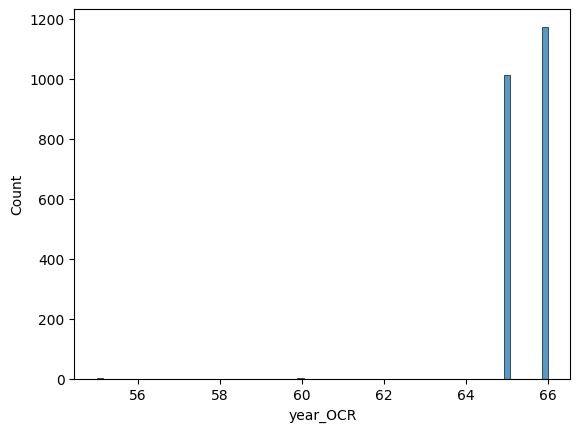

In [15]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [16]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [17]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
9422,1965.0,65.0
5688,1966.0,66.0
3748,1965.0,65.0
7040,1965.0,65.0
3596,1965.0,65.0
2050,1966.0,66.0
5985,1966.0,66.0
3757,1965.0,65.0
2208,1966.0,66.0
2148,1966.0,66.0


day:

<Axes: xlabel='day_of_year_OCR', ylabel='Count'>

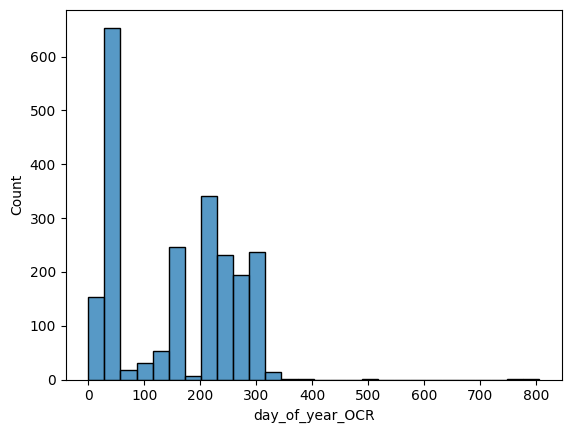

In [18]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [19]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
8266,293.0,293.0
7040,230.0,230.0
2683,35.0,35.0
2476,37.0,37.0
6965,228.0,228.0
5473,162.0,162.0
2279,45.0,45.0
2219,44.0,44.0
2337,48.0,48.0
9334,232.0,232.0


hour:

<Axes: xlabel='hour_OCR', ylabel='Count'>

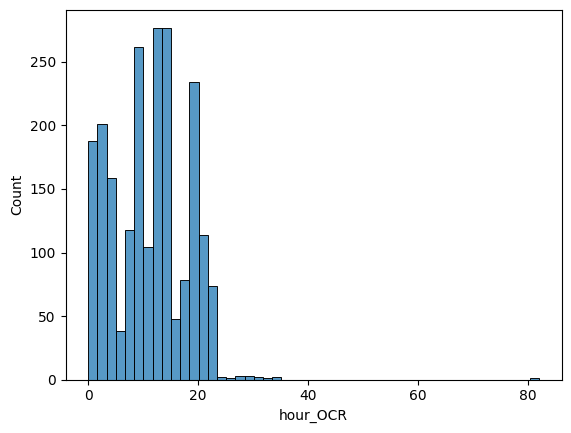

In [20]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [21]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
6068,13.0,13.0
9299,10.0,10.0
7097,8.0,8.0
1927,13.0,13.0
2587,4.0,4.0
8354,0.0,0.0
8337,16.0,16.0
8335,1.0,1.0
2252,21.0,21.0
4742,15.0,15.0


minute:

<Axes: xlabel='minute_OCR', ylabel='Count'>

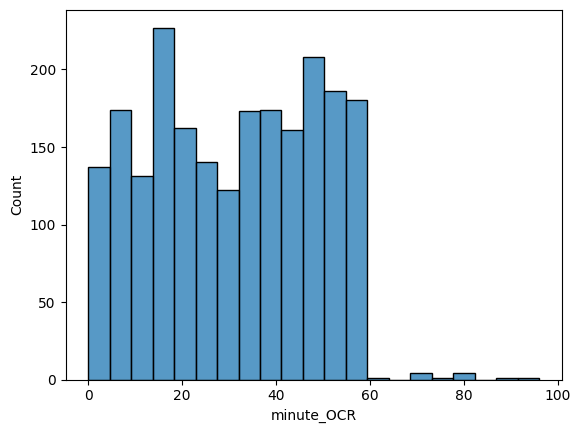

In [22]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [23]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
1980,53.0,53.0
7039,51.0,51.0
1472,6.0,6.0
3653,55.0,55.0
6891,27.0,27.0
6063,17.0,17.0
2845,1.0,1.0
8213,44.0,44.0
2208,21.0,21.0
4116,47.0,47.0


second:

<Axes: xlabel='second_OCR', ylabel='Count'>

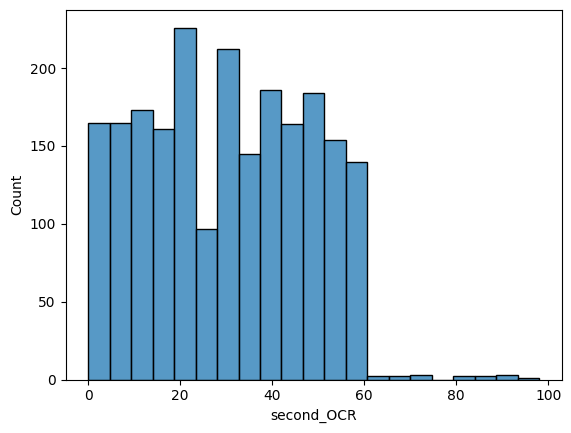

In [24]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [25]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
8363,36.0,36.0
2627,56.0,56.0
7915,41.0,41.0
2014,31.0,31.0
1864,41.0,41.0
8191,3.0,3.0
7063,1.0,1.0
2322,39.0,39.0
3107,4.0,4.0
5936,39.0,39.0


construct timestamp:

In [26]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

2187


In [27]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
8261,1965.0,08,01,12.0,54.0,48.0,1965-08-01 12:54:48,1
6065,1966.0,05,30,14.0,18.0,25.0,1966-05-30 14:18:25,1
4278,1965.0,08,01,14.0,8.0,4.0,1965-08-01 14:08:04,1
2228,1966.0,02,14,4.0,12.0,33.0,1966-02-14 04:12:33,1
2845,1966.0,02,20,14.0,1.0,20.0,1966-02-20 14:01:20,1
7876,1966.0,02,13,8.0,5.0,48.0,1966-02-13 08:05:48,1
8497,1965.0,10,13,15.0,38.0,16.0,1965-10-13 15:38:16,1
8258,1965.0,10,20,12.0,54.0,14.0,1965-10-20 12:54:14,1
9223,1965.0,08,20,6.0,59.0,7.0,1965-08-20 06:59:07,1
2812,1966.0,02,20,10.0,33.0,35.0,1966-02-20 10:33:35,1


#  

#### num - check timestamp components, construct timestamp:

In [28]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
34176,3.0,3.0,4.0,1.0,1.0,3.0,5.0,6.0,5.0,6.0
24034,5.0,0.0,1.0,1.0,2.0,3.0,4.0,2.0,5.0,1.0
25735,4.0,1.0,8.0,4.0,1.0,5.0,3.0,3.0,2.0,6.0
18325,4.0,2.0,0.0,6.0,0.0,4.0,0.0,3.0,0.0,3.0
25728,1.0,5.0,0.0,8.0,5.0,0.0,8.0,0.0,1.0,2.0
21021,4.0,1.0,3.0,6.0,0.0,9.0,1.0,5.0,0.0,7.0
35954,4.0,0.0,4.0,7.0,2.0,1.0,0.0,6.0,4.0,3.0
18619,4.0,2.0,1.0,9.0,0.0,8.0,4.0,6.0,2.0,3.0
14923,3.0,2.0,8.0,1.0,0.0,4.0,5.0,3.0,0.0,2.0
12152,3.0,1.0,0.0,5.0,2.0,3.0,4.0,4.0,3.0,1.0


year - adjust to baseline 1962:

<Axes: xlabel='year', ylabel='Count'>

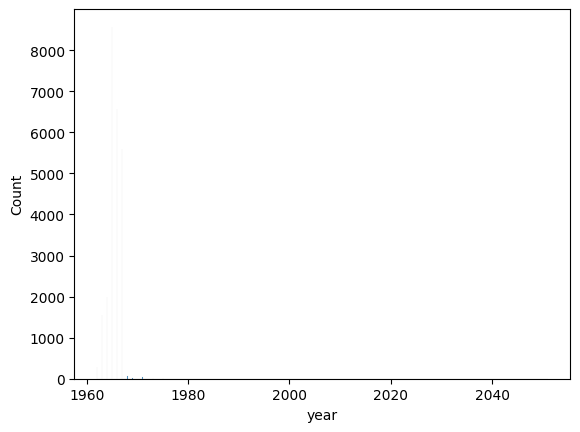

In [29]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [30]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
22412,1963.0,1.0
34508,1965.0,3.0
33492,1965.0,3.0
30492,1963.0,1.0
20173,1967.0,5.0
24677,1966.0,4.0
27649,1967.0,5.0
28082,1968.0,6.0
28273,1967.0,5.0
28135,1967.0,5.0


day:

<Axes: xlabel='day_1', ylabel='Count'>

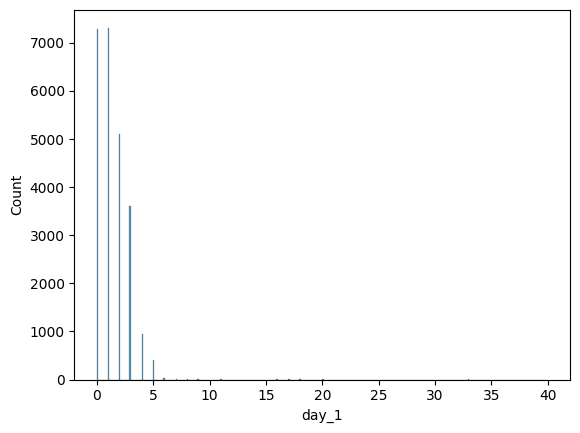

In [31]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [32]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

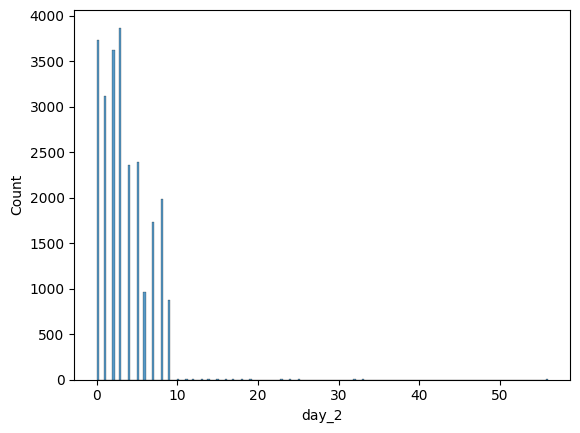

In [33]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [34]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

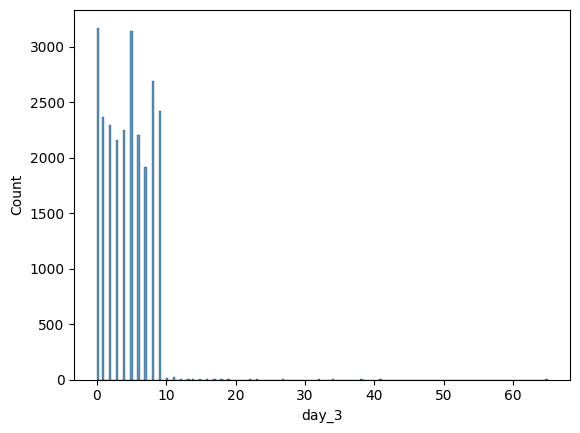

In [35]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [36]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [37]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

24716


,day_of_year,day_1,day_2,day_3
32579,318.0,3.0,1.0,8.0
15917,NaN,0.0,0.0,0.0
31215,55.0,0.0,5.0,5.0
35431,320.0,3.0,2.0,0.0
26280,26.0,0.0,2.0,6.0
12365,109.0,1.0,0.0,9.0
27482,137.0,1.0,3.0,7.0
29299,140.0,1.0,4.0,0.0
24072,25.0,0.0,2.0,5.0
27560,139.0,1.0,3.0,9.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

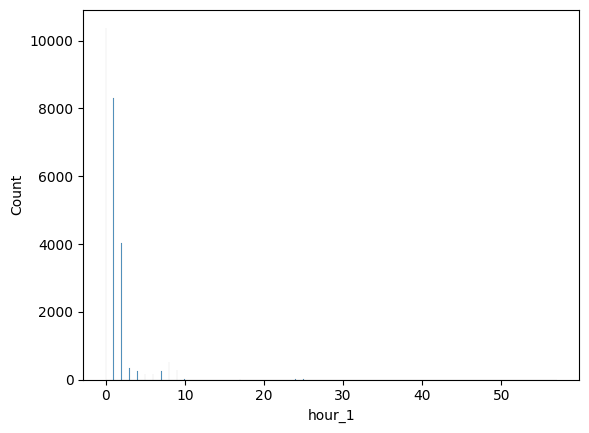

In [38]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [39]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

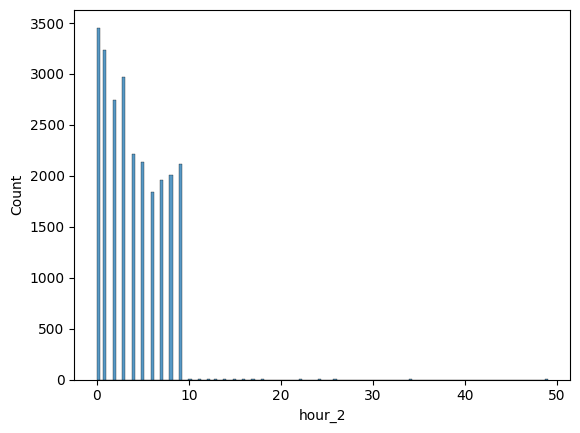

In [40]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [41]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [42]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

24716


,hour,hour_1,hour_2
28242,9.0,0.0,9.0
32606,3.0,0.0,3.0
10844,13.0,1.0,3.0
24690,20.0,2.0,0.0
24237,3.0,0.0,3.0
36795,23.0,2.0,3.0
12174,23.0,2.0,3.0
24109,10.0,1.0,0.0
34639,1.0,0.0,1.0
36767,23.0,2.0,3.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

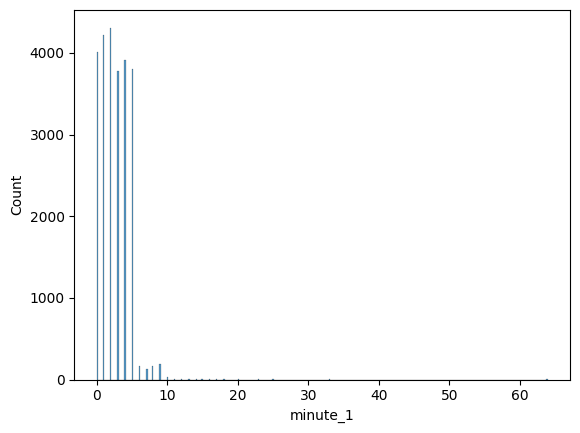

In [43]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [44]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

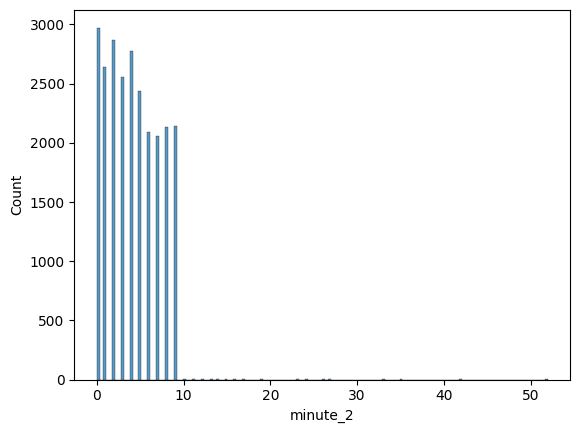

In [45]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [46]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [47]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

24716


,minute,minute_1,minute_2
12829,0.0,0.0,0.0
32082,1.0,0.0,1.0
21334,3.0,0.0,3.0
10951,12.0,1.0,2.0
9512,30.0,3.0,0.0
14419,38.0,3.0,8.0
14617,4.0,0.0,4.0
21208,24.0,2.0,4.0
35153,21.0,2.0,1.0
26497,56.0,5.0,6.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

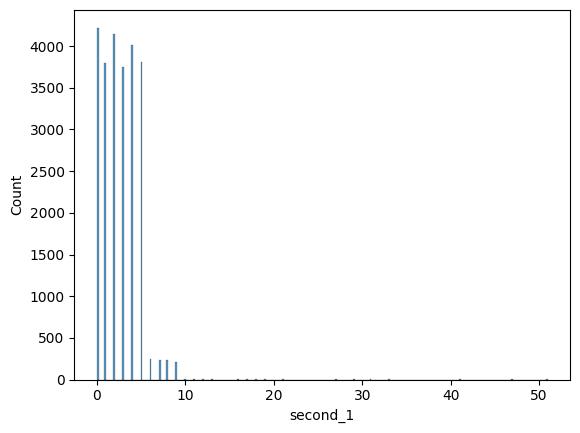

In [48]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [49]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

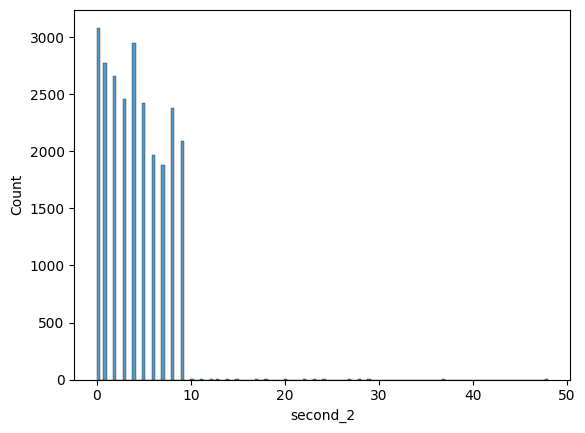

In [50]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [51]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [52]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

24716


,second,second_1,second_2
11646,4.0,0.0,4.0
25913,31.0,3.0,1.0
30903,25.0,2.0,5.0
23163,57.0,5.0,7.0
21259,18.0,1.0,8.0
33798,54.0,5.0,4.0
26816,0.0,0.0,0.0
20671,24.0,2.0,4.0
16314,49.0,4.0,9.0
16150,31.0,3.0,1.0


construct timestamp:

In [53]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

24716


In [54]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
17136,1966.0,08,16,3.0,40.0,54.0,1966-08-16 03:40:54,1
35157,1965.0,11,17,21.0,22.0,43.0,1965-11-17 21:22:43,1
10908,1965.0,01,27,6.0,36.0,31.0,1965-01-27 06:36:31,1
16888,1964.0,NaN,NaN,NaN,NaN,20.0,NaT,0
38137,1965.0,07,12,11.0,19.0,13.0,1965-07-12 11:19:13,1
33574,1965.0,08,07,2.0,45.0,16.0,1965-08-07 02:45:16,1
25751,1963.0,NaN,NaN,NaN,42.0,2.0,NaT,0
16923,1964.0,NaN,NaN,NaN,NaN,10.0,NaT,0
24233,1967.0,01,26,3.0,40.0,21.0,1967-01-26 03:40:21,1
20910,1966.0,05,17,21.0,32.0,3.0,1966-05-17 21:32:03,1


#  

#### dot - check timestamp components, construct timestamp:

In [55]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot
37362,NaN,8.0,9.0,9.0,8.0,13.0,0.0,2.0,8.0,10.0,NaN
13498,NaN,2.0,9.0,0.0,10.0,2.0,0.0,10.0,2.0,1.0,NaN
13520,NaN,2.0,1.0,8.0,1.0,12.0,14.0,12.0,12.0,1.0,NaN
15412,NaN,0.0,4.0,9.0,0.0,4.0,0.0,0.0,5.0,0.0,NaN
15133,NaN,0.0,4.0,1.0,1.0,8.0,9.0,0.0,9.0,12.0,NaN
38033,NaN,8.0,0.0,6.0,8.0,9.0,0.0,6.0,4.0,14.0,NaN
15675,NaN,0.0,12.0,10.0,9.0,0.0,14.0,8.0,4.0,9.0,NaN
15205,NaN,0.0,2.0,1.0,5.0,0.0,7.0,1.0,0.0,6.0,NaN
37679,NaN,8.0,12.0,4.0,0.0,1.0,0.0,9.0,2.0,10.0,NaN
10240,NaN,12.0,0.0,0.0,8.0,6.0,5.0,1.0,4.0,4.0,NaN


day:

<Axes: xlabel='day_1', ylabel='Count'>

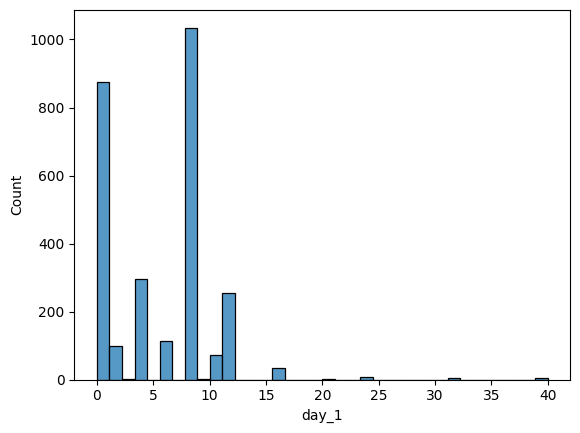

In [56]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [57]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

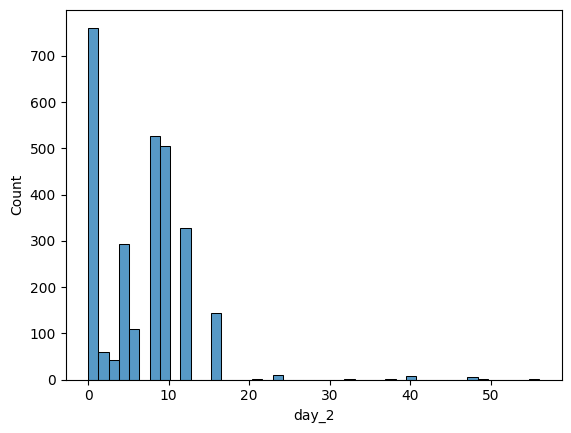

In [58]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [59]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

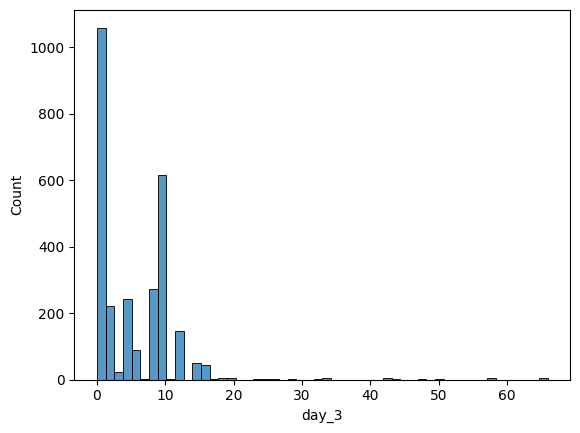

In [60]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [61]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [62]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

2800


,day_of_year,day_1,day_2,day_3
15858,NaN,NaN,NaN,0.0
15803,NaN,NaN,NaN,9.0
37284,NaN,4.0,3.0,0.0
37858,NaN,8.0,0.0,2.0
10275,80.0,0.0,8.0,0.0
15661,NaN,0.0,NaN,NaN
15610,NaN,0.0,NaN,NaN
13573,NaN,NaN,0.0,NaN
13594,NaN,2.0,NaN,4.0
13378,NaN,0.0,0.0,NaN


year - infer from day:

In [63]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_1324\2722169012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1962
C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_1324\2722169012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1963


,year,day_of_year,day_1,day_2,day_3
37366,NaN,NaN,8.0,9.0,9.0
13457,NaN,NaN,0.0,0.0,NaN
37903,NaN,NaN,8.0,0.0,0.0
37882,NaN,NaN,8.0,0.0,1.0
10138,1963.0,60.0,0.0,6.0,0.0
10344,NaN,NaN,0.0,NaN,0.0
13622,1963.0,2.0,0.0,0.0,2.0
10473,NaN,NaN,NaN,0.0,0.0
13721,1963.0,2.0,0.0,0.0,2.0
15153,NaN,NaN,4.0,1.0,1.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

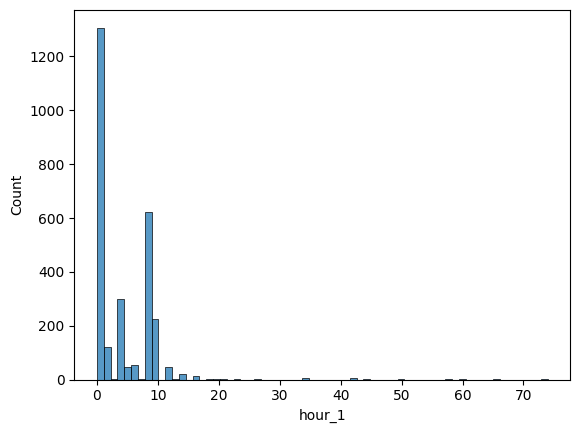

In [64]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [65]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

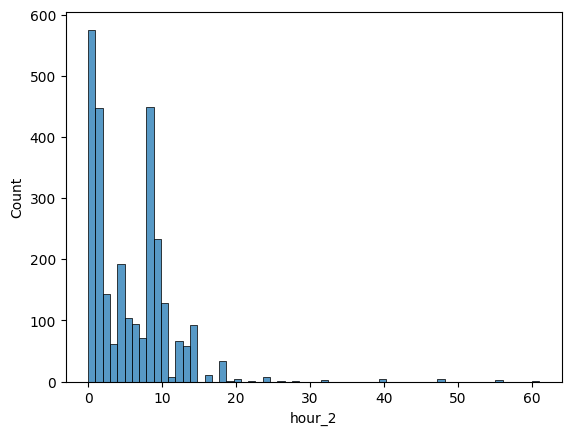

In [66]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [67]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [68]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

2800


,hour,hour_1,hour_2
10213,NaN,NaN,6.0
13569,NaN,4.0,NaN
37504,7.0,0.0,7.0
36922,1.0,0.0,1.0
15781,NaN,9.0,8.0
13394,NaN,4.0,8.0
15064,NaN,0.0,NaN
15633,NaN,9.0,0.0
37358,NaN,8.0,NaN
15163,NaN,9.0,0.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

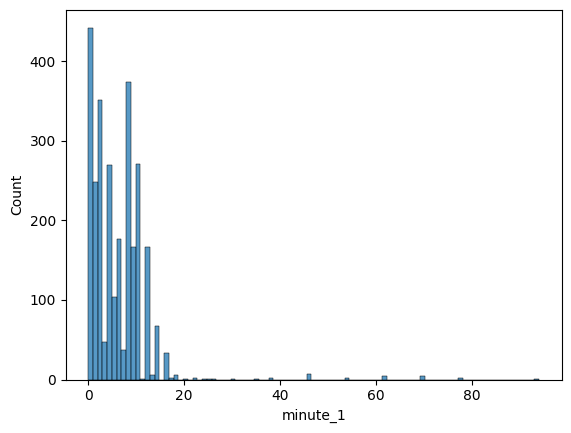

In [69]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [70]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

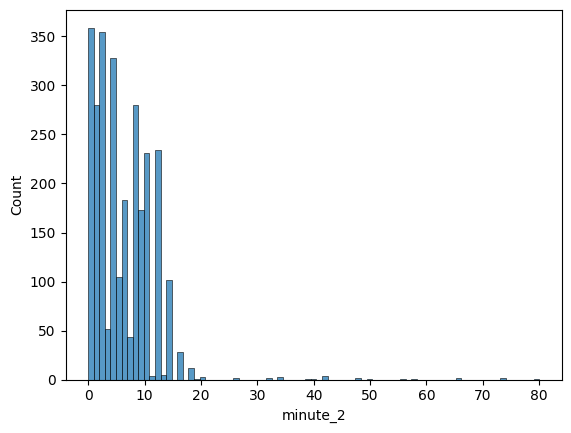

In [71]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [72]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [73]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

2800


,minute,minute_1,minute_2
10331,NaN,NaN,NaN
13734,NaN,6.0,NaN
13551,NaN,6.0,NaN
36845,0.0,0.0,0.0
10259,20.0,2.0,0.0
37007,NaN,8.0,NaN
36839,4.0,0.0,4.0
37284,11.0,1.0,1.0
13687,NaN,2.0,NaN
37000,NaN,8.0,NaN


second:

<Axes: xlabel='second_1', ylabel='Count'>

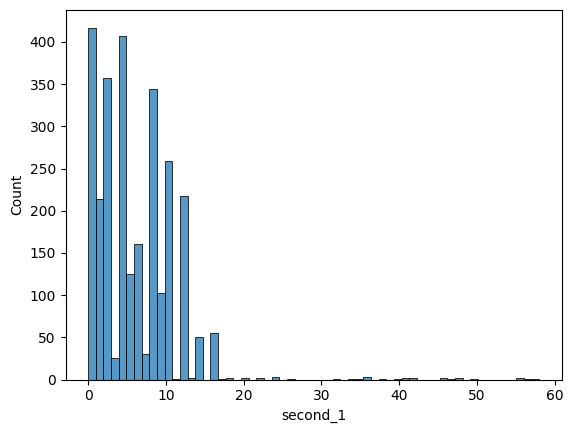

In [74]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [75]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

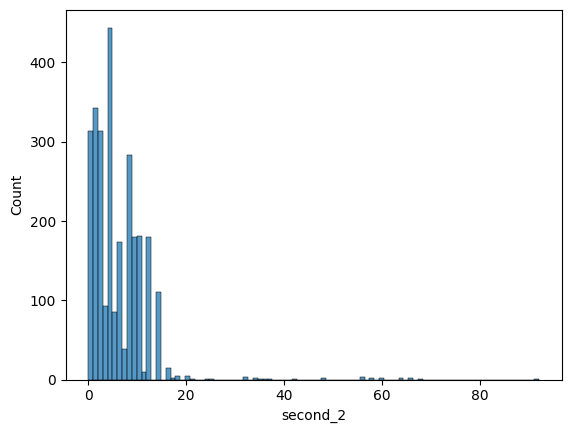

In [76]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [77]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [78]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

2800


,second,second_1,second_2
37726,NaN,0.0,NaN
36892,NaN,8.0,2.0
38053,NaN,NaN,9.0
13437,NaN,NaN,0.0
37018,9.0,0.0,9.0
37778,NaN,NaN,4.0
37678,2.0,0.0,2.0
37991,42.0,4.0,2.0
13544,24.0,2.0,4.0
10173,57.0,5.0,7.0


construct timestamp:

In [79]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

2800


In [80]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
37502,NaN,NaN,NaN,NaN,22.0,NaN,NaT,0
13347,NaN,NaN,NaN,12.0,NaN,NaN,NaT,0
37478,NaN,NaN,NaN,NaN,1.0,NaN,NaT,0
37944,NaN,NaN,NaN,NaN,25.0,NaN,NaT,0
10235,NaN,NaN,NaN,NaN,48.0,54.0,NaT,0
13722,1963.0,08,28,NaN,4.0,41.0,1963-08-28,4
37042,NaN,NaN,NaN,2.0,NaN,NaN,NaT,0
37202,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
37768,NaN,NaN,NaN,9.0,0.0,8.0,NaT,0
37353,NaN,NaN,NaN,NaN,1.0,NaN,NaT,0


#  

#### Check station number:

num2:

<Axes: xlabel='station_number_OCR', ylabel='Count'>

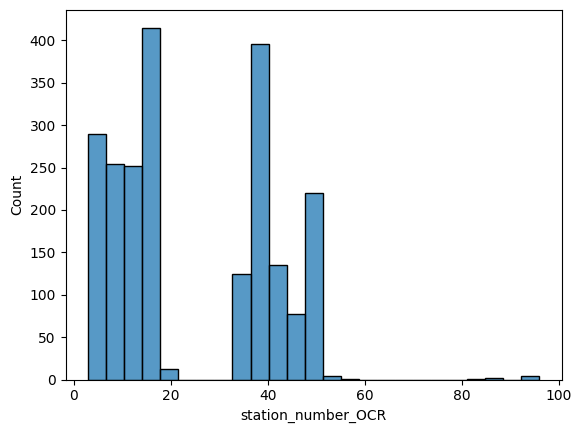

In [81]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [82]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
6153,15.0,15.0
8265,3.0,3.0
1380,50.0,50.0
8270,3.0,3.0
9402,43.0,43.0
9294,43.0,43.0
8414,3.0,3.0
1869,38.0,38.0
8403,3.0,3.0
3521,15.0,15.0


num:

<Axes: xlabel='station_number_1', ylabel='Count'>

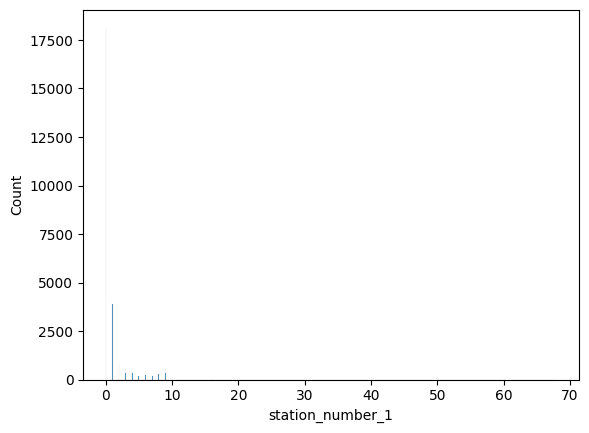

In [83]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [84]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='station_number_2', ylabel='Count'>

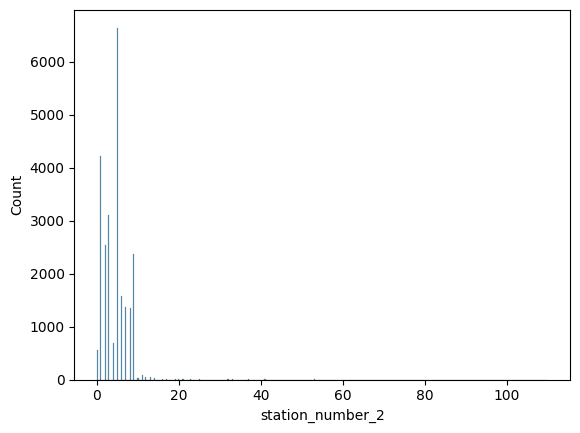

In [85]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [86]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [87]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

24716


,station_number,station_number_1,station_number_2
27576,6.0,0.0,6.0
21309,1.0,0.0,1.0
28840,8.0,0.0,8.0
17394,5.0,0.0,5.0
33807,18.0,1.0,8.0
34239,5.0,0.0,5.0
32266,3.0,0.0,3.0
19710,30.0,3.0,0.0
32753,3.0,0.0,3.0
18598,1.0,0.0,1.0


dot:

In [88]:
df_dot[['station_number']].sample(10)

,station_number
37425,10.0
13735,0.0
37090,1.0
37570,12.0
15473,10.0
15674,9.0
38002,14.0
37954,14.0
37973,14.0
13337,0.0


#  

#### Recombine results, save:

In [89]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

39255


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
20929,R014207951,2454-8A,145.png,num,1.685484,1482.692308,8.0,0.0,8.0,4.0,...,1966.0,137.0,21.0,37.0,1.0,1.0,05-17,05,17,1966-05-17 21:37:01
35258,R014207975,1089-B,212.png,num,1.572581,1267.924528,7.0,0.0,7.0,3.0,...,1965.0,323.0,9.0,29.0,14.0,1.0,11-19,11,19,1965-11-19 09:29:14
33672,R014207968,1207-5A,92.png,num,1.604839,1320.408163,5.0,0.0,5.0,3.0,...,1965.0,217.0,16.0,5.0,24.0,1.0,08-05,08,05,1965-08-05 16:05:24
28514,R014207959,2325-1B,226.png,num,2.627273,1291.071429,9.0,0.0,9.0,13.0,...,1975.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaT
29839,R014207962,1466-5A,26.png,num,1.612903,1381.818182,45.0,4.0,5.0,4.0,...,1966.0,19.0,9.0,5.0,30.0,1.0,01-19,01,19,1966-01-19 09:05:30
16750,R014207942,1950-5A,168.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
14771,R014207939,872-A,17.png,num,1.701613,1309.803922,5.0,0.0,5.0,3.0,...,1965.0,279.0,22.0,50.0,10.0,1.0,10-06,10,06,1965-10-06 22:50:10
8774,R014207844,2889-43B,5.png,loss,1.681452,1306.250000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
27833,R014207959,2313-3A,212.png,num,1.500000,1028.301887,3.0,0.0,3.0,1.0,...,1963.0,NaN,10.0,53.0,12.0,0.0,NaN,NaN,NaN,NaT
13417,R014207929F,470,Image0097.png,dot,1.540323,1330.232558,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaT


Save:

In [90]:
df_result2.to_csv(resultDir + 'result_postprocess_raw.csv', index=False)

#  

#### Retrieve station details:

In [91]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [92]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [93]:
#df_result_pp = pd.read_csv(resultDir + 'result_postprocess_raw.csv')
df_result2 = df_result2.loc[~pd.isna(df_result2['station_number'])]

In [94]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
166
1963-04-25 00:00:00
793
1963-08-06 00:00:00
942
1965-07-01 00:00:00
7121
After 1965-07-01 00:00:00
25616


In [95]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [96]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

25616


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
337,5.0,1963-02-14 00:31:02,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
5238,2.0,1965-02-20 09:36:23,PRI,"Prince Albert, SK, Canada",53.2N,105.9W
18944,6.0,1967-05-15 09:43:12,LIM,"Lima, Peru",11.8S,77.2W
19092,NaN,1966-05-16 10:20:15,NaN,NaN,NaN,NaN
12932,13.0,1966-05-12 23:24:19,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
8260,15.0,1966-05-29 02:35:41,WNK,"Winkfield, England, UK",51.4N,0.4W
12068,1.0,1966-08-07 08:41:59,BPT,"Blossom Point, MD, USA",38.4N,77.1W
17643,18.0,1967-01-25 20:34:28,WOO,"Woomera, Australia",31.1S,136.8E
12097,1.0,1966-08-07 10:29:17,BPT,"Blossom Point, MD, USA",38.4N,77.1W
238,3.0,1963-02-04 20:45:34,OTT,"Ottawa, Canada",45.4N,75.7W


#  

#### Save Master:

In [97]:
df_result5 = df_result4[~pd.isna(df_result4['Station_Code'])]
df_result5 = df_result5[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
print(len(df_result5))
df_result5.sample(10)

24191


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
13218,R014207949,2142-5B,244.png,num,1.544355,1267.924528,1967-01-06 15:55:57,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
3932,R014207939,862-B,2.png,num,1.500000,1173.584906,1964-01-03 02:55:57,1.0,6.0,FTM,"Fort Myers, FL, USA",26.6N,81.9W
19093,R014207959,2313-3A,64.png,num,1.500000,1216.981132,1966-05-16 10:20:21,1.0,3.0,FTM,"Fort Myers, FL, USA",26.6N,81.9W
16290,R014207954,2202-4B,176.png,num,1.500000,800.000000,1967-01-20 10:41:21,1.0,4.0,NEW,"St. John's, NL, Canada",47.6N,52.4W
10621,R014207942,1975-5B,179.png,num,1.745968,1127.272727,1966-08-15 10:13:11,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
9984,R014207942,1936-5B,195.png,num,1.685484,1285.185185,1966-07-18 10:18:28,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
12082,R014207946,1865-1B,26.png,num,1.504032,1285.714286,1966-08-06 02:47:53,1.0,1.0,BPT,"Blossom Point, MD, USA",38.4N,77.1W
238,R014207959,2313-3A,36.png,num,1.500000,698.113208,1963-02-04 20:45:34,1.0,3.0,OTT,"Ottawa, Canada",45.4N,75.7W
19956,R014207960,2549-5B,14.png,num,1.500000,1288.888889,1967-05-19 21:18:35,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
11322,R014207946,1826-1B,110.png,num,1.750000,1167.272727,1966-07-01 08:35:45,1.0,1.0,BPT,"Blossom Point, MD, USA",38.4N,77.1W


In [98]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_master.csv', index=False)